In [ ]:
# !pip -q install kaggle

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("abhaysharma38/indian-folk-art-gallery-high-resolution-images")

# print("Path to dataset files:", path)

100%|██████████| 837M/837M [00:39<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
dataset_path = "/content/drive/MyDrive/Indian_Folk_Art_Dataset"

Mounted at /content/drive


In [ ]:
# import os

# # Define the path where the dataset is stored
# dataset_path = "/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1"

# # List all the files and directories in the dataset path
# # for root, dirs, files in os.walk(dataset_path):
# #     for file in files:
# #         print(os.path.join(root, file))


Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-main/Kerala Mural Painting (Kerala)/844.jpg
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-main/Kerala Mural Painting (Kerala)/299.jpg
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-main/Kerala Mural Painting (Kerala)/629.jpg
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-main/Kerala Mural Painting (Kerala)/1097.jpg
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-main/Kerala Mural Painting (Kerala)/934.jpg
/root/.cache/kagglehub/datasets/abhaysharma38/indian-folk-art-gallery-high-resolution-images/versions/1/folk-art-dataset-ma

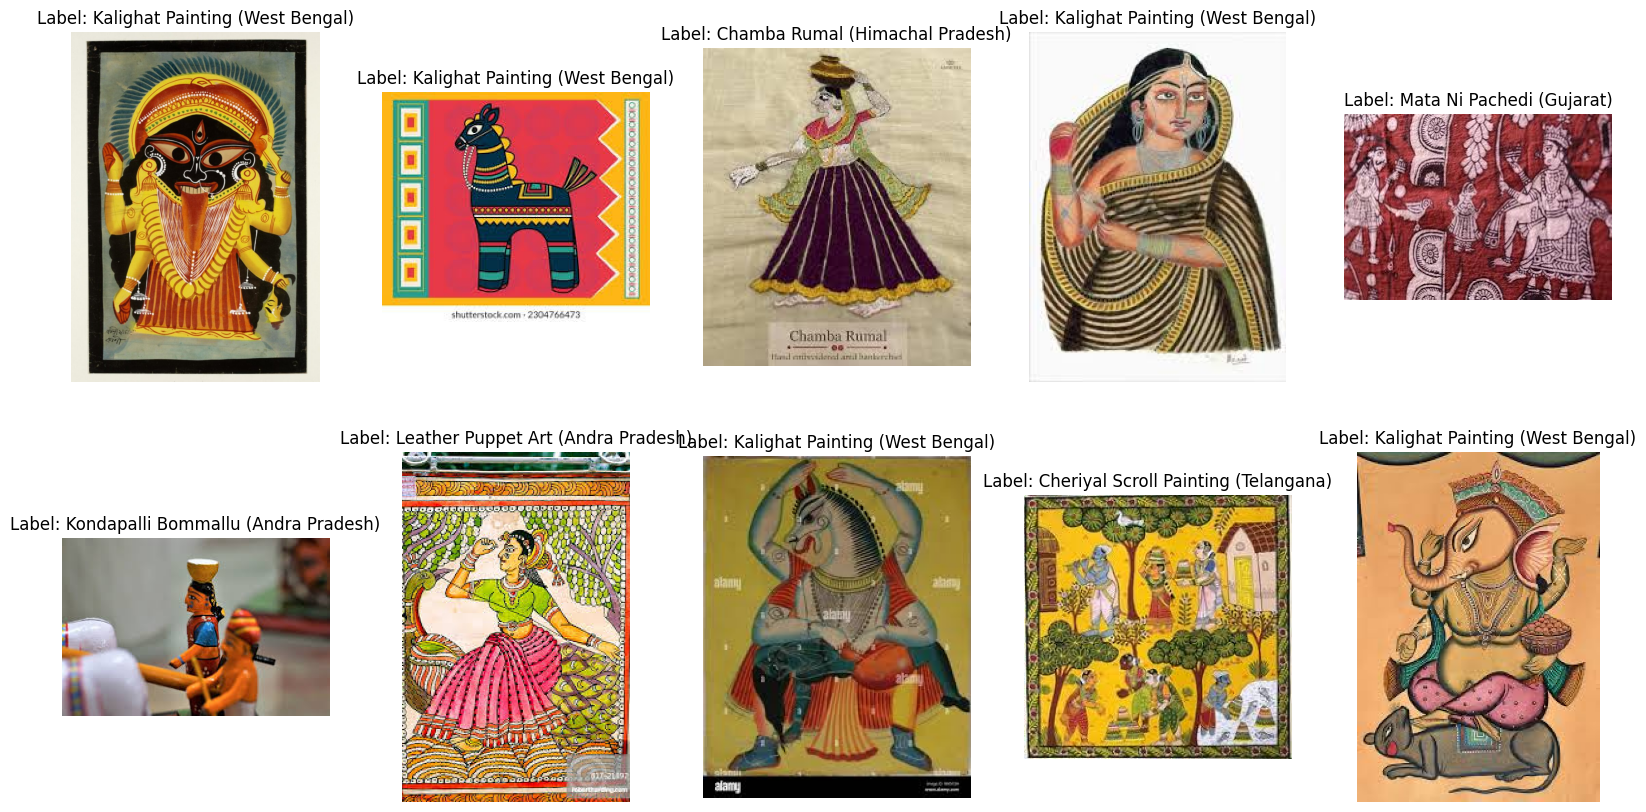

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/Indian_Folk_Art_Dataset/folk-art-dataset-main"

image_files_with_labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)
            image_files_with_labels.append((os.path.join(root, file), label))

random_images_with_labels = random.sample(image_files_with_labels, 10)

plt.figure(figsize=(20, 10))

for i, (image_file, label) in enumerate(random_images_with_labels):
    image = Image.open(image_file)
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Label: {label}")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from google.colab import drive

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_info}")
else:
    print("GPU not available. Training on CPU.")

# Partial Convolution Layer
class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        nn.init.constant_(self.mask_conv.weight, 1.0)  # Initialize the mask conv to have weights of 1
        for param in self.mask_conv.parameters():
            param.requires_grad = False  # Freeze mask conv

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        with torch.no_grad():
            updated_mask = self.mask_conv(mask)
        return output * (updated_mask > 0), updated_mask

# Dataset for Loading Images
class IndianFolkArtDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(root, file)
                            for root, _, files in os.walk(image_dir)
                            for file in files if file.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# U-Net with Partial Convolutions
class PartialConvUNet(nn.Module):
    def __init__(self):
        super(PartialConvUNet, self).__init__()
        self.encoder1 = PartialConv2d(3, 64, 7, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()  # Final output is normalized between 0 and 1
        )

    def forward(self, x, mask):
        enc_out, mask = self.encoder1(x, mask)
        enc_out = self.relu1(enc_out)
        enc_out = self.pool1(enc_out)
        dec_out = self.decoder(enc_out)
        return dec_out

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
dataset_path = "/content/drive/MyDrive/Indian_Folk_Art_Dataset"  # Update your dataset path
dataset = IndianFolkArtDataset(dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize model, loss function, and optimizer
model = PartialConvUNet().to(device)  # Ensure the model is sent to the correct device
criterion = nn.MSELoss()  # Example of loss; can be modified for perceptual loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images in data_loader:
            images = images.to(device)

            # Generate random masks for inpainting
            masks = torch.rand(images.shape).to(device) > 0.5  # Random binary masks

            # Forward pass
            outputs = model(images, masks.float())
            loss = criterion(outputs, images)  # Reconstruction loss

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader)}")

train_model(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Using GPU: Tesla T4


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from google.colab import drive
class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        nn.init.constant_(self.mask_conv.weight, 1.0)
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        with torch.no_grad():
            updated_mask = self.mask_conv(mask)
        return output * (updated_mask > 0), updated_mask

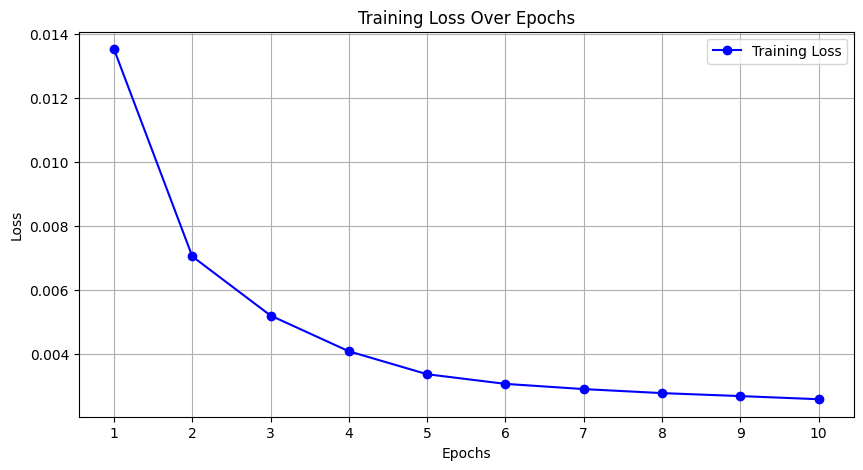

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()
plt.show()


In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 12547


In [ ]:
model = PartialConvUNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

<ipython-input-15-ba8bed51a52c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


PartialConvUNet(
  (encoder1): PartialConv2d(
    (input_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (mask_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  )
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Sigmoid()
  )
)